In [1]:
!pip install matplotlib
!pip install qutip
!pip install numpy 
!pip install scipy
!pip install Cython  

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_bosonic_proj_ev as me

from IPython.display import display, Math, Latex

In [34]:
L = 3 
dim = 2
expanded_bos_ops_list = [me.basic_bos_ops(L, dim)[n][m] for n in range(4) for m in range(L)]
expanded_bos_ops_list

[Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]],
 Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]],
 Quantum o

In [28]:
def callback(t, rhot):
    global rho
    rho = rhot

def simul(L = 3, dim = 5, bosonic_system = "tight-binding", coeff=3, temp = 1, 
          deltat=10., tmax = 200., distance=me.bures, do_project = True):
        
    global rho 
    loc_globalid = qutip.tensor([qutip.qeye(dim) for k in range(L)])
    
    expanded_bos_ops_list = [me.basic_bos_ops(L, dim)[n][m] for n in range(4) for m in range(L)]
    
    obs = [qutip.num(dim) for k in range(L)]
    
    sampling = max(int(10*coeff*deltat), 10)
    print("sampling", sampling)
    
    rho0 = me.two_body_gaussian_state(L, dim, 10**-6, False)
    
    unitary_ev = True
    if unitary_ev:
        c_op_list = None
    else:
        c_op_list = None
        
    rho = rho0
    approx_exp_vals = [[qutip.expect(op, rho) for op in expanded_bos_ops_list]]
    ts = [0]
    
    for i in range(int(tmax/deltat)):
        qutip.mesolve(H = me.bosonic_Hamiltonian(bosonic_system, L, dim, coeff, False),
                      rho0 = rho,
                      tlist = np.linspace(0, deltat, sampling),
                      c_ops = c_op_list,
                      e_ops = callback,
                      args={'L': L, 'dim': dim, 'bosonic_system': bosonic_system, 'coeff': coeff}
                     )
        ts.append(deltat*i)
        if do_project: 
            rho = me.proj_op(me.logM(rho), expanded_bos_ops_list, rho0)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = 2. * rho.tr()
            rho = (rho + rho.dag())/trrho
    
    newobs = [qutip.expect(rho, op) for op in obs]
    approx_exp_vals.append(newobs)
    
    result = {}
    result["ts"] = ts
    result["averages"] = np. array(approx_exp_vals)
    
    title = f" BW dinÃ¡mica cerrada gaussiana coeff={coeff}"
    if do_project:
        title = title + "_projected_"
        
    with open(title+".pkl", "wb") as f:
        pickle.dump(result, f)
        
    return result

In [32]:
resultsA = simul(L = 3, dim = 3, bosonic_system = "tight-binding", coeff=-.5, temp = 1, 
                               deltat=10., tmax = 200., distance=me.bures, do_project = False)
    
#resultsB = simul(L = 3, dim = 5, bosonic_system = "tight-binding", coeff=-.5, temp = 1, 
#                               deltat=10., tmax = 200., distance=me.bures, do_project = False)

for n in range(L): 
    plt.plot(resultsA["ts"], resultsA["averages"][:,n], label=r'$\langle a^{\dagger (n)}a^{(n)} \rangle_{ProyME}$'%n)
#    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=r'$\langle a^{\dagger (n)}a^{(n)} \rangle$_{Exact}'%n)

plt.legend()

sampling 10


Exception: Operator and state do not have same tensor structure: [3, 3, 3] and [3]

In [14]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.max_ent_app = None
        self.projrho0_app = None
        self.projrho_inst_app = None 

def simul(omega_bos=3, omega_s=3, temp=1, gaussian=False, deltat=10., tmax=500., distance=bures):
    basis_bos = [qutip.qeye(dim), qutip.create(dim),qutip.create(dim).dag(),qutip.num(dim)]
    H_bos = qutip.tensor(qutip.num(dim), qutip.qeye(2))
    H_i = qutip.tensor(.5*(qutip.create(dim)+qutip.destroy(dim)), qutip.sigmax())
    # Estado inicial
    rho0 = qutip.tensor((-qutip.num(dim)/temp).expm(), qutip.qeye(2)/2.)
    rho0 = rho0/rho0.tr()
    # Base
    if gaussian:
        basis_spin = [qutip.qeye(2), qutip.sigmax()]
        H_s = qutip.tensor(qutip.qeye(dim),qutip.sigmax())
    else:
        basis_spin = [qutip.qeye(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]
        H_s = qutip.tensor(qutip.qeye(dim),qutip.sigmaz())
        
    basis = base_orto(prod_basis(basis_bos, basis_spin), rho0)
    # Hamiltoniano
    H = omega_bos * H_bos + omega_s * H_s + H_i

    sampling = int(10*max(1,omega_bos, omega_s)*deltat)
    
    states = [rho0]
    rho = rho0    
    ts= [0]
    for i in range(int(tmax/deltat)):
        result = qutip.mesolve(H, states[-1], np.linspace(0,deltat, sampling))
        states.append(result.states[-1])
        ts.append(deltat*i)
    
    result = Result(ts, states)
    result.times = ts
    result.states = states
    result.max_ent_app = np.array([error_maxent_state(rho, basis, distance) for rho in states])
    result.projrho0_app = np.array([error_proj_state(rho, rho0, basis,distance) for rho in states])
    result.projrho_inst_app = np.array([error_proj_state(rho, qutip.tensor(rho.ptrace([0]),rho.ptrace([1])), 
                                                         basis, distance) for rho in states])
    
    if gaussian:
        title = distance.__name__ + f" - DinÃ¡mica gaussiana    dim={dim} wb={omega_bos} dw={abs(omega_s-omega_bos)} "
    else:
        title = distance.__name__ + f" - DinÃ¡mica no gaussiana dim={dim} wb={omega_bos} dw={abs(omega_s-omega_bos)} " 

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result, title

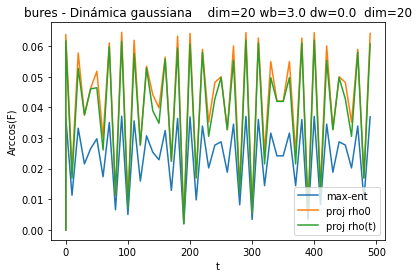

In [15]:
## DinÃ¡mica Gaussiana, resonante


result, title = simul(omega_bos=3., omega_s=3., temp=1, 
                      gaussian=True, 
                      deltat=10., tmax=500., 
                      distance=bures)

plt.plot(result.times, result.max_ent_app, label="max-ent")
plt.plot(result.times, result.projrho0_app, label="proj rho0")
plt.plot(result.times, result.projrho_inst_app, label="proj rho(t)")
plt.xlabel("t")
plt.ylabel("Arccos(F)")

plt.legend()
plt.title(title + f" dim={dim}")
plt.savefig(title + f" dim={dim}.svg")